Reference file (uploaded): /mnt/data/RM Framework.docx
Generated boards: 150
Saved results to: results_ab_vs_id_role_phase.csv

Overall descriptive statistics (grouped by method):
method                        AB         AB+ID
nodes        count    300.000000    300.000000
             mean     541.093333    512.340000
             std     1419.108330   1381.084000
             min        1.000000      1.000000
             25%        3.000000      3.000000
             50%       25.000000     25.000000
             75%      341.250000    277.500000
             max    11530.000000  11846.000000
prunes       count    300.000000    300.000000
             mean     210.803333    200.290000
             std      583.472311    564.200413
             min        0.000000      0.000000
             25%        0.000000      0.000000
             50%        5.000000      5.500000
             75%      112.750000     98.250000
             max     4910.000000   4997.000000
time_ms      count   

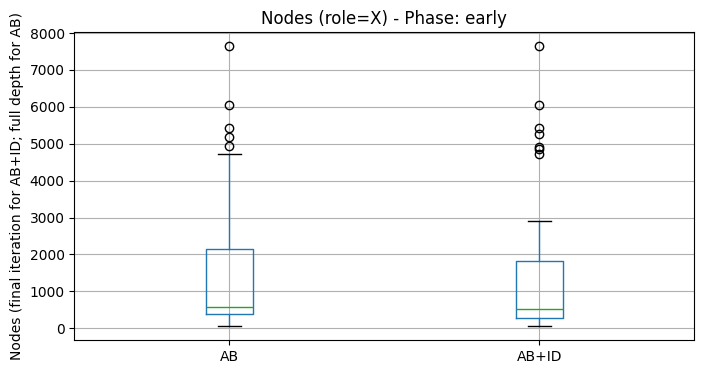

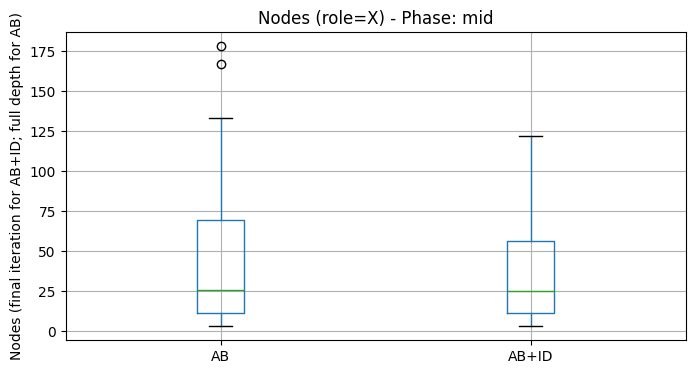

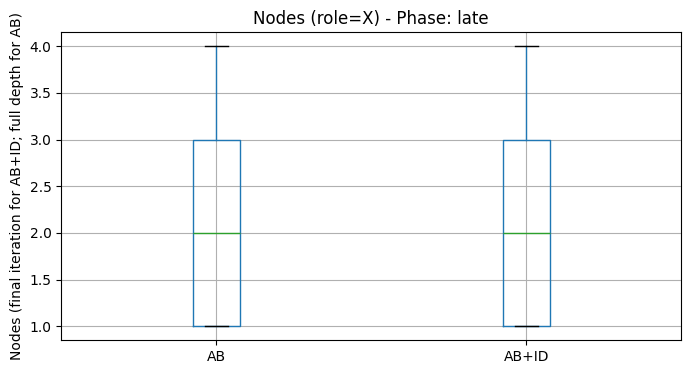

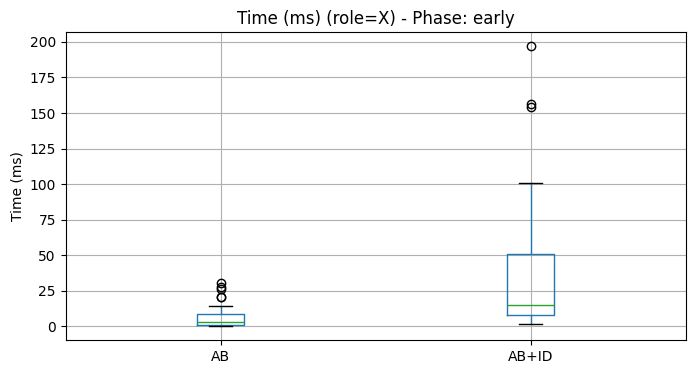

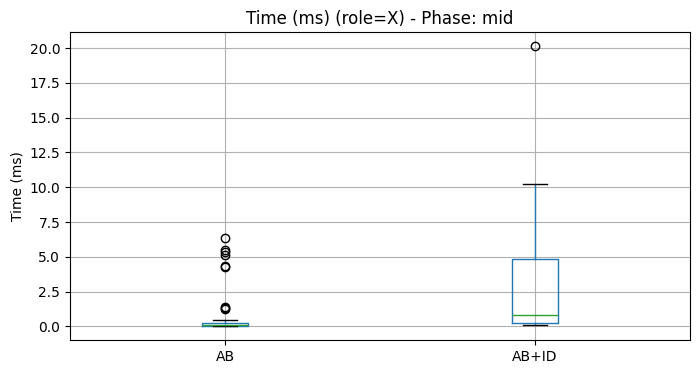

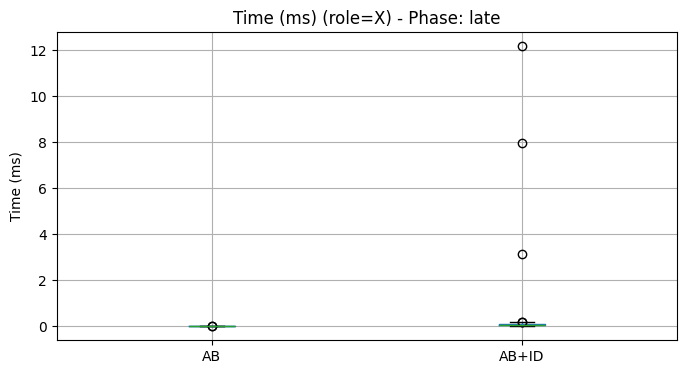

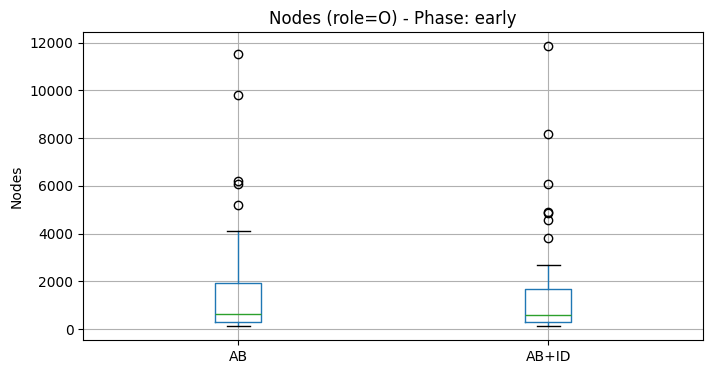

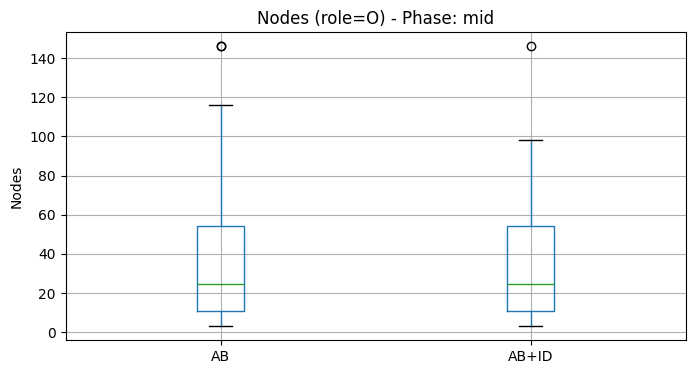

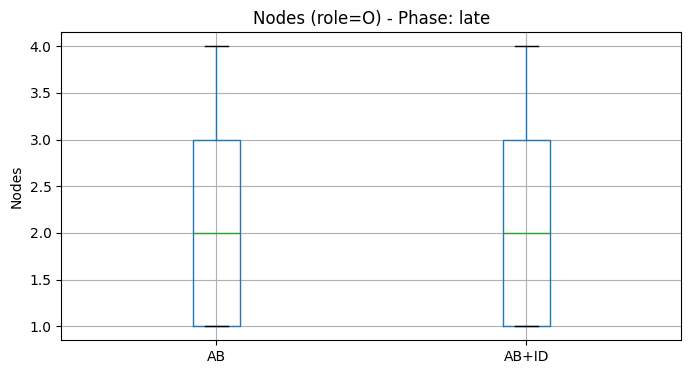

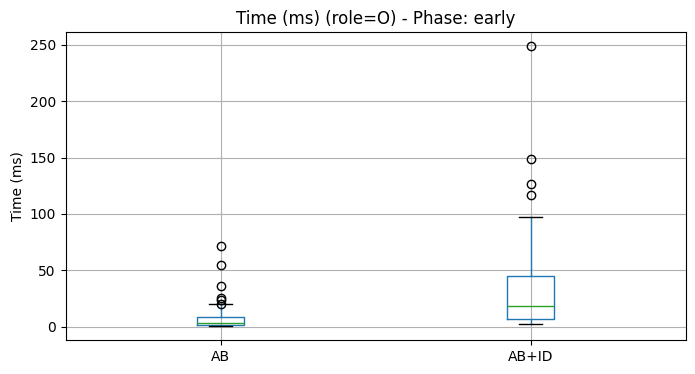

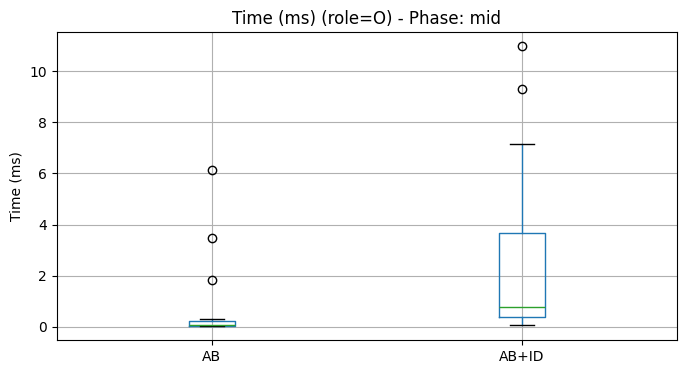

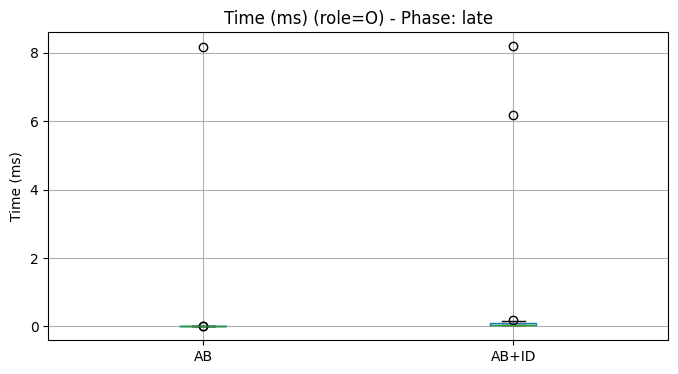


Aggregated table (phase, role, method):
    phase role method    nodes                            prunes         \
                          mean median          std count    mean median   
0   early    O     AB  1648.74  636.5  2383.782236    50  653.84  216.5   
1   early    O  AB+ID  1538.98  582.5  2280.297398    50  609.66  208.5   
2   early    X     AB  1505.78  583.0  1817.631508    50  589.14  201.0   
3   early    X  AB+ID  1457.68  533.5  1859.177451    50  572.32  180.0   
4    late    O     AB     2.20    2.0     1.142857    50    0.00    0.0   
5    late    O  AB+ID     2.20    2.0     1.142857    50    0.00    0.0   
6    late    X     AB     2.20    2.0     1.142857    50    0.00    0.0   
7    late    X  AB+ID     2.20    2.0     1.142857    50    0.00    0.0   
8     mid    O     AB    42.86   24.5    40.320659    50   10.40    5.0   
9     mid    O  AB+ID    35.92   24.5    31.295067    50    9.42    6.0   
10    mid    X     AB    44.78   25.5    44.978584    50   

In [1]:

REF_FILE_PATH = '/mnt/data/RM Framework.docx'
print("Reference file (uploaded):", REF_FILE_PATH)


import random, time, pandas as pd
import matplotlib.pyplot as plt
from math import isnan

random.seed(42)

WIN_POS = [
    [0,1,2], [3,4,5], [6,7,8],
    [0,3,6], [1,4,7], [2,5,8],
    [0,4,8], [2,4,6]
]

def check_winner(board):
    for a,b,c in WIN_POS:
        if board[a] == board[b] == board[c] and board[a] != '-':
            return board[a]
    return None

def get_available_moves(board):
    return [i for i, cell in enumerate(board) if cell == '-']

def get_phase(board):
    filled = 9 - board.count('-')
    if filled <= 3:
        return 'early'
    elif filled <= 6:
        return 'mid'
    else:
        return 'late'

def alphabeta_run(board, max_depth, maximizing_player=True, move_order=None):
    """
    Run one full alphabeta search to max_depth, return:
    (best_score, best_move, nodes_count, prune_count)
    - maximizing_player: True if root is X (maximizer), False if root is O (minimizer)
    - move_order: optional list of moves (indices) to prioritize at each node
    """
    nodes = 0
    prunes = 0

    def rec(node_board, depth, alpha, beta, maximizing):
        nonlocal nodes, prunes
        nodes += 1

        winner = check_winner(node_board)
        if winner == 'X':
            return 1
        if winner == 'O':
            return -1
        if '-' not in node_board or depth == 0:
            return 0

        moves = get_available_moves(node_board)
        if move_order:
            ordered = [m for m in move_order if m in moves] + [m for m in moves if m not in (move_order or [])]
            moves = ordered

        if maximizing:
            value = -999
            for move in moves:
                nb = list(node_board)
                nb[move] = 'X'
                val = rec(nb, depth-1, alpha, beta, False)
                if val > value: value = val
                alpha = max(alpha, value)
                if alpha >= beta:
                    prunes += 1
                    break
            return value
        else:
            value = 999
            for move in moves:
                nb = list(node_board)
                nb[move] = 'O'
                val = rec(nb, depth-1, alpha, beta, True)
                if val < value: value = val
                beta = min(beta, value)
                if alpha >= beta:
                    prunes += 1
                    break
            return value

    best_score = -999 if maximizing_player else 999
    best_move = None
    moves_top = get_available_moves(board)
    if move_order:
        moves_top = [m for m in move_order if m in moves_top] + [m for m in moves_top if m not in (move_order or [])]

    for move in moves_top:
        child = list(board)
        child[move] = 'X' if maximizing_player else 'O'
        score = rec(child, max_depth-1, -999, 999, not maximizing_player)
        if maximizing_player:
            if score > best_score:
                best_score = score
                best_move = move
        else:
            if score < best_score:
                best_score = score
                best_move = move

    return best_score, best_move, nodes, prunes

def alphabeta_iterative_deepening(board, max_depth, maximizing_player=True):
    """
    Returns:
    final_score, final_best_move,
    cumulative_nodes, cumulative_prunes,
    final_nodes, final_prunes,
    total_time_ms
    """
    cumulative_nodes = 0
    cumulative_prunes = 0
    prev_best_move = None
    final_nodes = 0
    final_prunes = 0
    final_score = None
    final_best_move = None

    start = time.time()
    for depth in range(1, max_depth+1):
        move_order = [prev_best_move] if prev_best_move is not None else None
        score, best_move, nodes, prunes = alphabeta_run(board, depth, maximizing_player=maximizing_player, move_order=move_order)
        cumulative_nodes += nodes
        cumulative_prunes += prunes
        prev_best_move = best_move
        final_score = score
        final_best_move = best_move
        final_nodes = nodes
        final_prunes = prunes
    total_time = (time.time() - start) * 1000
    return final_score, final_best_move, cumulative_nodes, cumulative_prunes, final_nodes, final_prunes, total_time

def generate_nonterminal_board(filled):
    attempts = 0
    while True:
        board = ['-'] * 9
        positions = random.sample(range(9), filled)
        for i in positions:
            board[i] = random.choice(['X','O'])
        if check_winner(board) is None:
            return board
        attempts += 1
        if attempts > 200:
            return board

unique_board_strings = set()
boards = []

while len([b for b in boards if get_phase(b) == 'early']) < 50:
    board_list = generate_nonterminal_board(random.randint(1,3))
    board_str = ''.join(board_list)
    if board_str not in unique_board_strings:
        unique_board_strings.add(board_str)
        boards.append(board_list)

while len([b for b in boards if get_phase(b) == 'mid']) < 50:
    board_list = generate_nonterminal_board(random.randint(4,6))
    board_str = ''.join(board_list)
    if board_str not in unique_board_strings:
        unique_board_strings.add(board_str)
        boards.append(board_list)

while len([b for b in boards if get_phase(b) == 'late']) < 50:
    board_list = generate_nonterminal_board(random.randint(7,8))
    board_str = ''.join(board_list)
    if board_str not in unique_board_strings:
        unique_board_strings.add(board_str)
        boards.append(board_list)

print("Generated boards:", len(boards))

results = []
max_depth = 9

for board in boards:
    board_str = ''.join(board)
    phase = get_phase(board)
    t0 = time.time()
    s_ab_x, best_ab_x, nodes_ab_x, prunes_ab_x = alphabeta_run(board, max_depth, maximizing_player=True, move_order=None)
    t_ab_x = (time.time() - t0) * 1000
    s_id_x, best_id_x, cum_nodes_id_x, cum_prunes_id_x, final_nodes_id_x, final_prunes_id_x, t_id_x = alphabeta_iterative_deepening(board, max_depth, maximizing_player=True)

    t0 = time.time()
    s_ab_o, best_ab_o, nodes_ab_o, prunes_ab_o = alphabeta_run(board, max_depth, maximizing_player=False, move_order=None)
    t_ab_o = (time.time() - t0) * 1000
    s_id_o, best_id_o, cum_nodes_id_o, cum_prunes_id_o, final_nodes_id_o, final_prunes_id_o, t_id_o = alphabeta_iterative_deepening(board, max_depth, maximizing_player=False)

    results.append({
        "board": board_str,
        "phase": phase,
        "role": "X",
        "method": "AB",
        "nodes": nodes_ab_x,
        "prunes": prunes_ab_x,
        "time_ms": t_ab_x,
        "final_nodes_id": final_nodes_id_x,
        "final_prunes_id": final_prunes_id_x,
        "cum_nodes_id": cum_nodes_id_x,
        "cum_prunes_id": cum_prunes_id_x,
        "id_time_ms": t_id_x
    })
    results.append({
        "board": board_str,
        "phase": phase,
        "role": "X",
        "method": "AB+ID",
        "nodes": final_nodes_id_x,
        "prunes": final_prunes_id_x,
        "time_ms": t_id_x,
        "final_nodes_id": final_nodes_id_x,
        "final_prunes_id": final_prunes_id_x,
        "cum_nodes_id": cum_nodes_id_x,
        "cum_prunes_id": cum_prunes_id_x,
        "id_time_ms": t_id_x
    })
    results.append({
        "board": board_str,
        "phase": phase,
        "role": "O",
        "method": "AB",
        "nodes": nodes_ab_o,
        "prunes": prunes_ab_o,
        "time_ms": t_ab_o,
        "final_nodes_id": final_nodes_id_o,
        "final_prunes_id": final_prunes_id_o,
        "cum_nodes_id": cum_nodes_id_o,
        "cum_prunes_id": cum_prunes_id_o,
        "id_time_ms": t_id_o
    })
    results.append({
        "board": board_str,
        "phase": phase,
        "role": "O",
        "method": "AB+ID",
        "nodes": final_nodes_id_o,
        "prunes": final_prunes_id_o,
        "time_ms": t_id_o,
        "final_nodes_id": final_nodes_id_o,
        "final_prunes_id": final_prunes_id_o,
        "cum_nodes_id": cum_nodes_id_o,
        "cum_prunes_id": cum_prunes_id_o,
        "id_time_ms": t_id_o
    })

df = pd.DataFrame(results)
csv_path = "results_ab_vs_id_role_phase.csv"
df.to_csv(csv_path, index=False)
print("Saved results to:", csv_path)


print("\nOverall descriptive statistics (grouped by method):")
print(df.groupby(['method'])[['nodes','prunes','time_ms','cum_nodes_id']].describe().transpose())

print("\nSummary by phase and method:")
phase_summary = df.groupby(['phase','method','role'])[['nodes','prunes','time_ms','cum_nodes_id']].agg(['mean','median','std','count'])
print(phase_summary)

for phase in ['early','mid','late']:
    subset = df[(df['phase']==phase) & (df['role']=='X')]
    if subset.empty:
        continue
    plt.figure(figsize=(8,4))
    subset_pivot = subset.pivot(index='board', columns='method', values='nodes')
    subset_pivot[['AB','AB+ID']].boxplot()
    plt.title(f"Nodes (role=X) - Phase: {phase}")
    plt.ylabel("Nodes (final iteration for AB+ID; full depth for AB)")
    plt.show()

for phase in ['early','mid','late']:
    subset = df[(df['phase']==phase) & (df['role']=='X')]
    if subset.empty:
        continue
    plt.figure(figsize=(8,4))
    subset_pivot_time = subset.pivot(index='board', columns='method', values='time_ms')
    subset_pivot_time[['AB','AB+ID']].boxplot()
    plt.title(f"Time (ms) (role=X) - Phase: {phase}")
    plt.ylabel("Time (ms)")
    plt.show()

for phase in ['early','mid','late']:
    subset = df[(df['phase']==phase) & (df['role']=='O')]
    if subset.empty:
        continue
    plt.figure(figsize=(8,4))
    subset_pivot = subset.pivot(index='board', columns='method', values='nodes')
    subset_pivot[['AB','AB+ID']].boxplot()
    plt.title(f"Nodes (role=O) - Phase: {phase}")
    plt.ylabel("Nodes")
    plt.show()

for phase in ['early','mid','late']:
    subset = df[(df['phase']==phase) & (df['role']=='O')]
    if subset.empty:
        continue
    plt.figure(figsize=(8,4))
    subset_pivot_time = subset.pivot(index='board', columns='method', values='time_ms')
    subset_pivot_time[['AB','AB+ID']].boxplot()
    plt.title(f"Time (ms) (role=O) - Phase: {phase}")
    plt.ylabel("Time (ms)")
    plt.show()


agg = df.groupby(['phase','role','method'])[['nodes','prunes','time_ms','cum_nodes_id']].agg(['mean','median','std','count'])
agg = agg.reset_index()
print("\nAggregated table (phase, role, method):")
print(agg)


agg.to_csv("aggregated_summary_phase_role.csv", index=False)
print("Saved aggregated summary: aggregated_summary_phase_role.csv")


print("\nAll done. Files created:\n -", csv_path, "\n - aggregated_summary_phase_role.csv")

In [2]:
import pandas as pd


def create_summary_table(df):
    summary_rows = []

    for phase in ["early", "mid", "late"]:
        for role in ["X", "O"]:
            subset = df[(df["phase"] == phase) & (df["role"] == role)]

            if subset.empty:
                continue

            for method in ["AB", "AB+ID"]:
                sub2 = subset[subset["method"] == method]

                summary_rows.append({
                    "Phase": phase.capitalize(),
                    "Role": role,
                    "Method": method,
                    "Nodes Mean": sub2["nodes"].mean(),
                    "Nodes Median": sub2["nodes"].median(),
                    "Nodes Std": sub2["nodes"].std(),
                    "Time Mean (ms)": sub2["time_ms"].mean(),
                    "Time Median (ms)": sub2["time_ms"].median(),
                    "Time Std (ms)": sub2["time_ms"].std(),
                    "Count": len(sub2)
                })

    summary_df = pd.DataFrame(summary_rows)


    summary_df = summary_df.sort_values(
        by=["Phase", "Role", "Method"],
        ascending=[True, True, True]
    ).reset_index(drop=True)

    return summary_df



summary_table = create_summary_table(df)

summary_table


,Phase,Role,Method,Nodes Mean,Nodes Median,Nodes Std,Time Mean (ms),Time Median (ms),Time Std (ms),Count
0,Early,O,AB,1648.74,636.5,2383.782236,8.694634,2.999187,13.712060,50
1,Early,O,AB+ID,1538.98,582.5,2280.297398,36.326857,17.934084,47.228605,50
2,Early,X,AB,1505.78,583.0,1817.631508,6.226072,3.425241,7.481846,50
3,Early,X,AB+ID,1457.68,533.5,1859.177451,34.653950,14.885783,43.386050,50
4,Late,O,AB,2.20,2.0,1.142857,0.171161,0.006795,1.153870,50
5,Late,O,AB+ID,2.20,2.0,1.142857,0.353084,0.055075,1.424321,50
6,Late,X,AB,2.20,2.0,1.142857,0.008273,0.006437,0.004743,50
7,Late,X,AB+ID,2.20,2.0,1.142857,0.532665,0.064254,2.056989,50
8,Mid,O,AB,42.86,24.5,40.320659,0.329161,0.076056,0.996985,50
9,Mid,O,AB+ID,35.92,24.5,31.295067,2.252588,0.770330,2.622845,50


In [3]:
import pandas as pd
import numpy as np
import os # Added import for os

# fungsi Cohen's d untuk paired samples
def cohens_d_paired(x, y):
    diff = x - y
    # Handle the case where std is 0 to avoid division by zero
    if diff.std(ddof=1) == 0:
        return 0.0  # Return 0.0 or np.nan for no variance
    return diff.mean() / diff.std(ddof=1)

results = []

# Load the dataframe from the saved CSV file
csv_path = "results_ab_vs_id_role_phase.csv"

# --- Modification starts here ---
if not os.path.exists(csv_path):
    print(f"Error: The required file '{csv_path}' was not found. Please ensure that the cell 'VAD4ihyKhk7K' (which generates this CSV) has been executed successfully in the current session.")
    # Create an empty DataFrame to avoid NameError later if the file is missing
    df = pd.DataFrame()
else:
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading '{csv_path}': {e}. Please check the file's integrity.")
        df = pd.DataFrame()
# --- Modification ends here ---

# Check if df is empty (meaning the file was not found or an error occurred during loading)
if not df.empty:
    # Pivot the dataframe to get AB and AB+ID values side-by-side for paired comparison
    processed_df = df.pivot_table(
        index=['board', 'phase', 'role'],
        columns='method',
        values=['nodes', 'time_ms']
    ).reset_index()

    # Flatten multi-level columns and rename for clarity
    # The column names will now be like 'nodes_AB', 'nodes_AB+ID', 'time_ms_AB', 'time_ms_AB+ID'
    # Corrected renaming to match the checks
    processed_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in processed_df.columns.values]

    for phase in ['early', 'mid', 'late']:
        for role in ['X', 'O']:
            subset = processed_df[(processed_df['phase'] == phase) & (processed_df['role'] == role)]

            # Ensure there's data for comparison before calculating Cohen's d
            if not subset.empty and \
               'nodes_AB' in subset.columns and 'nodes_AB+ID' in subset.columns and \
               'time_ms_AB' in subset.columns and 'time_ms_AB+ID' in subset.columns:

                d_nodes = cohens_d_paired(
                    subset['nodes_AB'],
                    subset['nodes_AB+ID']
                )

                d_time = cohens_d_paired(
                    subset['time_ms_AB'],
                    subset['time_ms_AB+ID']
                )

                results.append({
                    'Phase': phase,
                    'Role': role,
                    'EffectSize_Nodes': d_nodes,
                    'EffectSize_Time': d_time
                })
            else:
                 print(f"Warning: No data or missing expected columns for Phase: {phase}, Role: {role} after processing. Skipping Cohen's d calculation.")

    effect_df = pd.DataFrame(results)
else:
    print("Cohen's d calculation skipped due to missing or empty input data.")
    effect_df = pd.DataFrame() # Ensure effect_df is defined even if data is missing
effect_df

,Phase,Role,EffectSize_Nodes,EffectSize_Time
0,early,X,0.246888,-0.781873
1,early,O,0.305234,-0.781508
2,mid,X,0.499129,-0.541835
3,mid,O,0.472189,-0.698306
4,late,X,0.000000,-0.254958
5,late,O,0.000000,-0.097814


In [4]:
import numpy as np
from scipy.stats import ttest_rel, wilcoxon

def cohens_d_paired(a, b):
    diff = a - b
    return diff.mean() / diff.std(ddof=1)


In [7]:
results = []

for phase in df['phase'].unique():
    for role in df['role'].unique():
        subset = df[(df['phase']==phase) & (df['role']==role)]

        ab = subset[subset['method']=='AB']
        id_ = subset[subset['method']=='AB+ID']

        ab = ab.sort_values('board')
        id_ = id_.sort_values('board')

        t_nodes = ttest_rel(ab['nodes'], id_['nodes'])
        d_nodes = cohens_d_paired(ab['nodes'].values, id_['nodes'].values)

        t_time = ttest_rel(ab['time_ms'], id_['time_ms'])
        d_time = cohens_d_paired(ab['time_ms'].values, id_['time_ms'].values)

        results.append({
            "Phase": phase,
            "Role": role,
            "p_value_nodes": t_nodes.pvalue,
            "effect_size_nodes": d_nodes,
            "p_value_time": t_time.pvalue,
            "effect_size_time": d_time
        })

summary_df = pd.DataFrame(results)
summary_df


/tmp/ipython-input-1144550902.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return diff.mean() / diff.std(ddof=1)


,Phase,Role,p_value_nodes,effect_size_nodes,p_value_time,effect_size_time
0,early,X,0.087120,0.246888,0.000001,-0.781873
1,early,O,0.035829,0.305234,0.000001,-0.781508
2,mid,X,0.000917,0.499129,0.000363,-0.541835
3,mid,O,0.001613,0.472189,0.000010,-0.698306
4,late,X,NaN,NaN,0.077568,-0.254958
5,late,O,NaN,NaN,0.492424,-0.097814
